# Double integrator

For this example we demonstrate learning control for a double integrator system. In this case we learn the control from directly interacting with the system in a typical RL scenario. 

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [ ]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

In [1]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

# Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph.  

In [2]:
# Double integrator parameters
nx = 2
nu = 1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# closed loop system definition
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

xnext = lambda x, u: x @ A.T + u @ B.T
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')
cl_system = System([policy, double_integrator])
# cl_system.show()

# Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the systemn operates in. 

In [3]:
# Training dataset generation
train_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3333,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=3333,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

# Optimization problem

We want to learn a controller that stabilizes the double integrator system. In other words we would like a control policy that pushes the system to stay at the origin. 

In [4]:
# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.001 * (u == 0.)^2  # control penalty
regulation_loss = 5. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

# Optimize problem with a system rollout of 2 time steps


In [5]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer,
    epochs=500,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric='dev_loss',
    warmup=400,
)

# Train model with prediction horizon of 2
cl_system.nsteps = 2
best_model = trainer.train()

C:\Users\drgo694\OneDrive - PNNL\Documents\Codes_dev\neuromancer\neuromancer\src\neuromancer\constraint.py:163: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
C:\Users\drgo694\OneDrive - PNNL\Documents\Codes_dev\neuromancer\neuromancer\src\neuromancer\constraint.py:163: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 3, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)


epoch: 0  train_loss: 100.69471740722656
epoch: 1  train_loss: 100.39545440673828
epoch: 2  train_loss: 100.10104370117188
epoch: 3  train_loss: 99.80980682373047
epoch: 4  train_loss: 99.52073669433594
epoch: 5  train_loss: 99.23339080810547
epoch: 6  train_loss: 98.94620513916016
epoch: 7  train_loss: 98.65731811523438
epoch: 8  train_loss: 98.3660888671875
epoch: 9  train_loss: 98.07113647460938
epoch: 10  train_loss: 97.77237701416016
epoch: 11  train_loss: 97.46917724609375
epoch: 12  train_loss: 97.16181945800781
epoch: 13  train_loss: 96.8486557006836
epoch: 14  train_loss: 96.5284423828125
epoch: 15  train_loss: 96.19982147216797
epoch: 16  train_loss: 95.86255645751953
epoch: 17  train_loss: 95.52058410644531
epoch: 18  train_loss: 95.17672729492188
epoch: 19  train_loss: 94.82441711425781
epoch: 20  train_loss: 94.46138000488281
epoch: 21  train_loss: 94.08633422851562
epoch: 22  train_loss: 93.70057678222656
epoch: 23  train_loss: 93.30551147460938
epoch: 24  train_loss: 92.

epoch: 200  train_loss: 19.927776336669922
epoch: 201  train_loss: 19.926530838012695
epoch: 202  train_loss: 19.92531394958496
epoch: 203  train_loss: 19.924121856689453
epoch: 204  train_loss: 19.92296028137207
epoch: 205  train_loss: 19.921829223632812
epoch: 206  train_loss: 19.92072105407715
epoch: 207  train_loss: 19.919639587402344
epoch: 208  train_loss: 19.918590545654297
epoch: 209  train_loss: 19.917566299438477
epoch: 210  train_loss: 19.916568756103516
epoch: 211  train_loss: 19.915599822998047
epoch: 212  train_loss: 19.914649963378906
epoch: 213  train_loss: 19.91373634338379
epoch: 214  train_loss: 19.912845611572266
epoch: 215  train_loss: 19.911983489990234
epoch: 216  train_loss: 19.911142349243164
epoch: 217  train_loss: 19.91032600402832
epoch: 218  train_loss: 19.909530639648438
epoch: 219  train_loss: 19.908756256103516
epoch: 220  train_loss: 19.90800666809082
epoch: 221  train_loss: 19.907276153564453
epoch: 222  train_loss: 19.90656852722168
epoch: 223  train_

epoch: 397  train_loss: 19.870285034179688
epoch: 398  train_loss: 19.87021255493164
epoch: 399  train_loss: 19.870136260986328
epoch: 400  train_loss: 19.87006187438965
epoch: 401  train_loss: 19.869993209838867
epoch: 402  train_loss: 19.869918823242188
epoch: 403  train_loss: 19.869848251342773
epoch: 404  train_loss: 19.869773864746094
epoch: 405  train_loss: 19.86970329284668
epoch: 406  train_loss: 19.869630813598633
epoch: 407  train_loss: 19.869556427001953
epoch: 408  train_loss: 19.869483947753906
epoch: 409  train_loss: 19.86941146850586
epoch: 410  train_loss: 19.869335174560547
epoch: 411  train_loss: 19.869258880615234
epoch: 412  train_loss: 19.869184494018555
epoch: 413  train_loss: 19.869108200073242
epoch: 414  train_loss: 19.869029998779297
epoch: 415  train_loss: 19.868959426879883
epoch: 416  train_loss: 19.868881225585938
epoch: 417  train_loss: 19.868810653686523
epoch: 418  train_loss: 19.868741989135742
epoch: 419  train_loss: 19.868669509887695
epoch: 420  tra

# Evaluate best model on a system rollout of 50 time steps


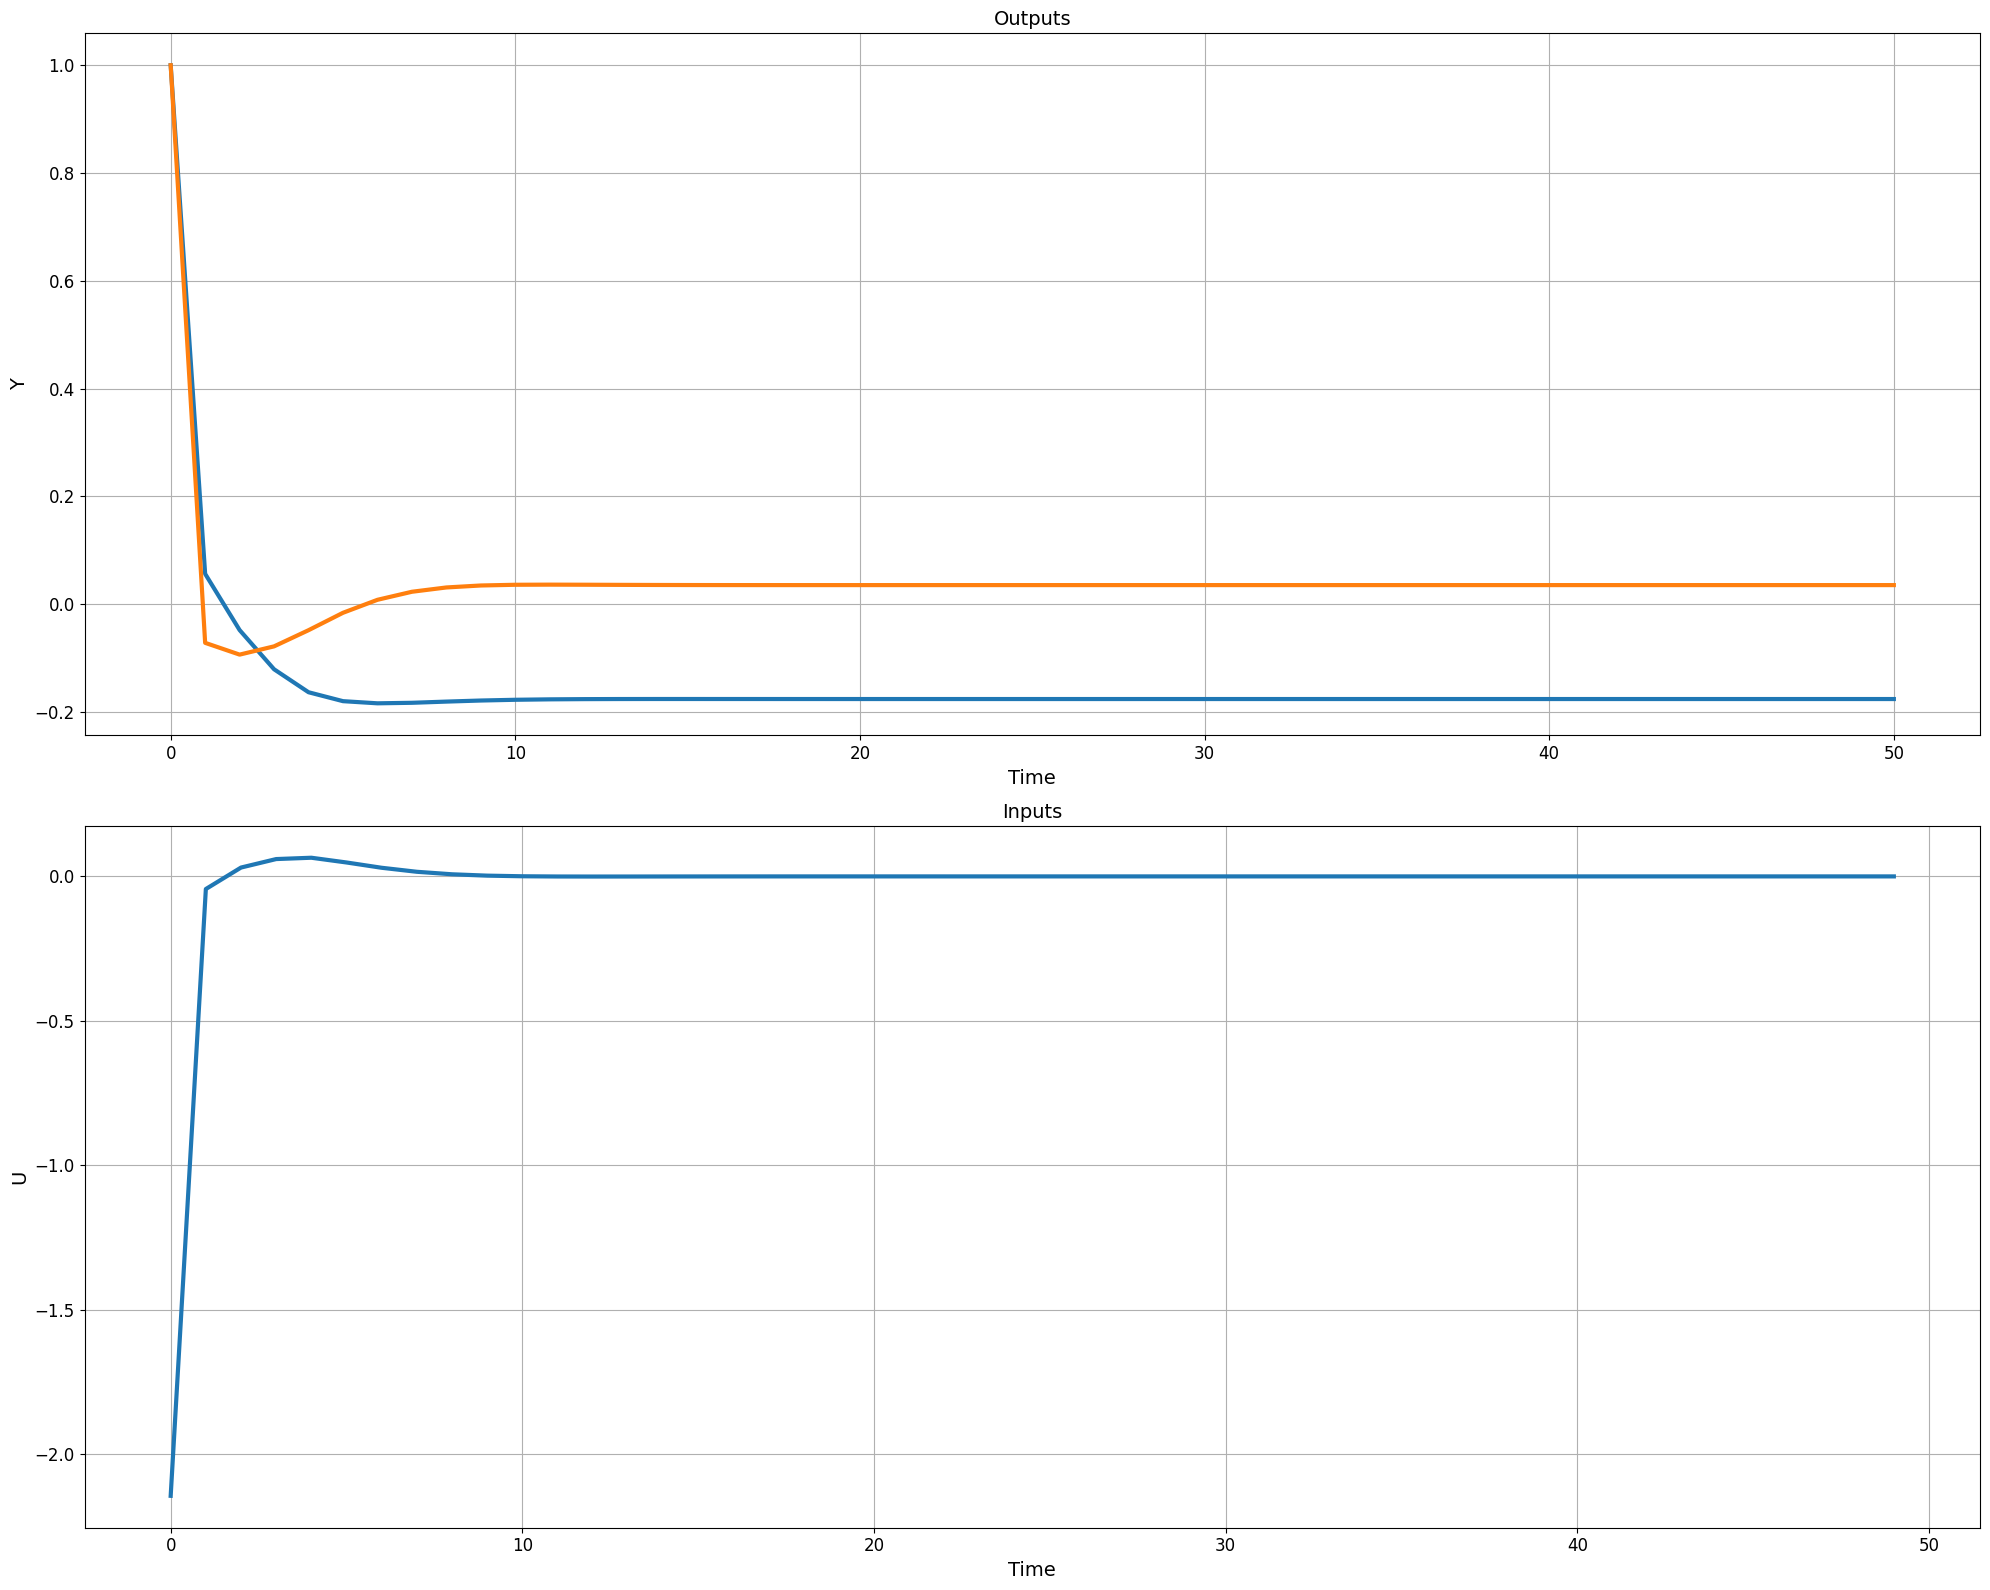

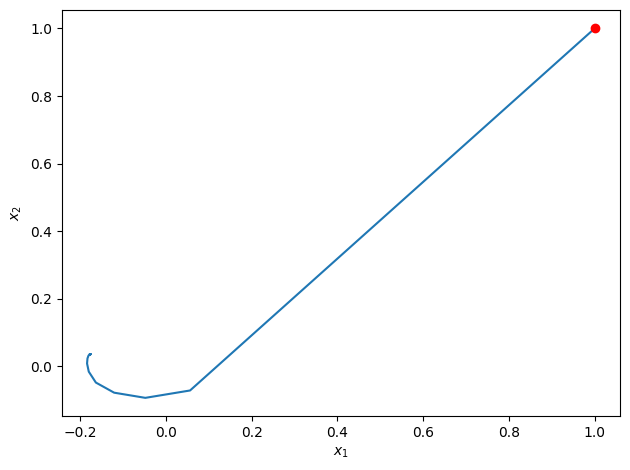

<Figure size 640x480 with 0 Axes>

In [6]:
# Test best model with prediction horizon of 50
problem.load_state_dict(best_model)
data = {'X': torch.ones(1, 1, nx, dtype=torch.float32)}
cl_system.nsteps = 50
trajectories = cl_system(data)
pltCL(Y=trajectories['X'].detach().reshape(51, 2), U=trajectories['U'].detach().reshape(50, 1), figname='cl.png')
pltPhase(X=trajectories['X'].detach().reshape(51, 2), figname='phase.png')